In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn as nn
from torch.optim import Adam

In [2]:
%matplotlib inline

In [47]:
from tqdm.notebook import tqdm

In [12]:
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True)

In [15]:
trainset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [6]:
display(trainset[0][0])

In [16]:
transform = torchvision.transforms.PILToTensor()

In [17]:
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

In [19]:
for X, label in trainloader:
    print(X.shape)
    print(X.dtype)
    break

torch.Size([32, 1, 28, 28])
torch.uint8


<img src="auto_encoder.png" alt="auto_encoder" style="width: 800px;"/>

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1 = nn.Linear(32*7*7, 512)
        self.lin2 = nn.Linear(512, 1)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(inp.shape[0], -1)
        out = self.lin1(out)
        return self.lin2(self.relu(out))

In [21]:
encoder = Encoder()

In [22]:
for X, label in trainloader:
    X = X.to(torch.float32)
    out = encoder(X)
    break

In [13]:
out.shape

torch.Size([32, 1])

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.lin2 = nn.Linear(128, 512)
        self.lin3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()

    def forward(self, z):
        out = self.lin1(z)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.relu(out)
        out = self.lin3(out)
        out = out.reshape(z.shape[0], 28, 28)
        return out

In [23]:
decoder = Decoder()

In [24]:
for X, label in trainloader:
    X = X.to(torch.float32)
    print(X.shape)
    out = encoder(X)
    X_hat = decoder(out).unsqueeze(1)
    print(X_hat.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, inp):
        out = self.encoder(inp)
        return self.decoder(out)

In [25]:
auto_encoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = Adam(auto_encoder.parameters(), lr=0.001)

In [19]:
epochs = 30
for e in tqdm(range(epochs)):
    for X, label in trainloader:
        X = X.to(torch.float32)
        X_hat = auto_encoder(X).unsqueeze(1)
        loss = criterion(X_hat, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
torch.save(auto_encoder.state_dict(), 'mnist_auto_encoder.pt')

In [9]:
auto_encoder = Autoencoder()
auto_encoder.load_state_dict(torch.load('mnist_auto_encoder.pt'))

/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_60592/381404954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  auto_encoder.load_state_dict(torch.load('mnist

<All keys matched successfully>

In [30]:
def sample_image(cls): # sample image of a particular class from the dataset
    for i, data in enumerate(trainset):
        if data[1]==cls:
            return data

In [31]:
sample = sample_image(2)

In [32]:
sample[0].shape

torch.Size([1, 28, 28])

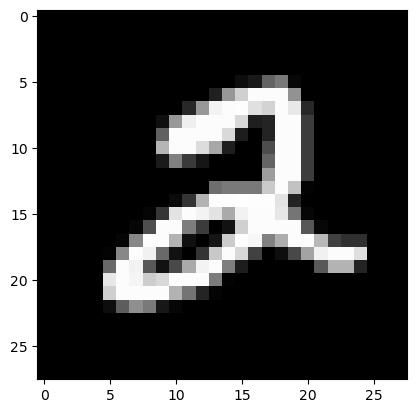

In [33]:
plt.imshow(sample[0].squeeze(0).numpy(), cmap='gray')

In [34]:
auto_encoder.eval()

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lin1): Linear(in_features=1568, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=1, out_features=128, bias=True)
    (lin2): Linear(in_features=128, out_features=512, bias=True)
    (lin3): Linear(in_features=512, out_features=784, bias=True)
    (relu): ReLU()
  )
)

In [35]:
out = auto_encoder(sample[0].to(torch.float32))

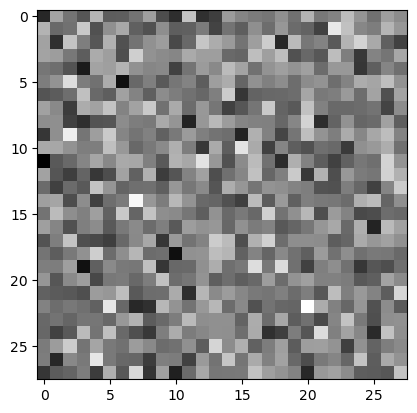

In [36]:
plt.imshow(out.squeeze(0).detach().numpy(), cmap='gray')

In [37]:
auto_encoder.encoder(sample[0].to(torch.float32))

tensor([[4.8473]], grad_fn=<AddmmBackward0>)

In [ ]:
# Sample 10 images for the 10 digits and compare look into the value of z

In [38]:
for i in range(10):
    sample = sample_image(i)
    z = auto_encoder.encoder(sample[0].to(torch.float32))
    print(i, z)

0 tensor([[4.9084]], grad_fn=<AddmmBackward0>)
1 tensor([[3.0161]], grad_fn=<AddmmBackward0>)
2 tensor([[4.8473]], grad_fn=<AddmmBackward0>)
3 tensor([[7.0449]], grad_fn=<AddmmBackward0>)
4 tensor([[-0.2948]], grad_fn=<AddmmBackward0>)
5 tensor([[5.8225]], grad_fn=<AddmmBackward0>)
6 tensor([[3.3698]], grad_fn=<AddmmBackward0>)
7 tensor([[5.3197]], grad_fn=<AddmmBackward0>)
8 tensor([[5.9885]], grad_fn=<AddmmBackward0>)
9 tensor([[8.9050]], grad_fn=<AddmmBackward0>)


In [39]:
inp = torch.tensor([[205.0]])

In [40]:
out = auto_encoder.decoder(inp)

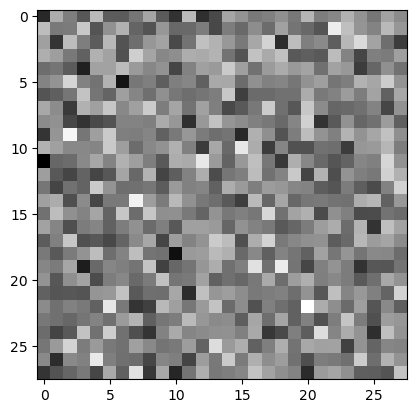

In [41]:
plt.imshow(out.squeeze(0).detach().numpy(), cmap='gray')

# Variational auto-encoder

<img src="vae.png" alt="vae" style="width: 800px;"/>

$$
\Large D_{KL}\left[N(\mu, \sigma) \parallel N(0, 1)\right] = -\frac{1}{2}\left(\log\sigma^2 + 1 - \sigma^2 - \mu^2 \right)
$$

In [42]:
class Encoder(nn.Module):
    def __init__(self, z=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1 = nn.Linear(32*7*7, 512)
        self.lin_m = nn.Linear(512, 1) # we will predict \mu and \sigma
        self.lin_s = nn.Linear(512, 1)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(inp.shape[0], -1)
        out = self.lin1(out)
        return self.lin_m(self.relu(out)), self.lin_s(self.relu(out))

In [43]:
class Variationaautoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder() # same decoder coud be used

    def forward(self, X):
        m, var = self.encoder(X)
        # sample z = \mu + \epsilon*\sigma
        z_norm = torch.randn(m.shape[0],1) # generate epsilon
        z = m + z_norm*var
        return self.decoder(z.unsqueeze(1)), m, var # we need \mu and \sigma to compute loss

In [44]:
def kl_div(m, s):
    return 0.5*(m**2 + s**2 - 1 - torch.log(s**2))

In [45]:
vae = Variationaautoencoder()
optimizer = Adam(vae.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [48]:
epochs = 15
for e in tqdm(range(epochs)):
    running_loss = 0
    batches = 0
    for X, label in trainloader:
        batches+=1
        X = X.to(torch.float32)
        X_hat, m, s = vae(X)
        #print(m,s)
        loss = criterion(X_hat.unsqueeze(1), X) + torch.mean(kl_div(m, s))
        running_loss+=loss.detach().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Loss at the end of epoch {e}: {running_loss/batches}")

  0%|          | 0/15 [00:00<?, ?it/s]

Loss at the end of epoch 0: 3976.581391015625
Loss at the end of epoch 1: 3607.765866927083
Loss at the end of epoch 2: 3522.4250453125
Loss at the end of epoch 3: 3441.882746744792
Loss at the end of epoch 4: 3392.792167057292
Loss at the end of epoch 5: 3353.304527864583
Loss at the end of epoch 6: 3324.455843098958
Loss at the end of epoch 7: 3308.3760522135417
Loss at the end of epoch 8: 3274.3953166666665
Loss at the end of epoch 9: 3287.9056220052084
Loss at the end of epoch 10: 3251.5440983072917
Loss at the end of epoch 11: 3221.917442578125
Loss at the end of epoch 12: 3327.6282341145834
Loss at the end of epoch 13: 3275.6079768229165
Loss at the end of epoch 14: 3203.7576359375


In [49]:
torch.save(vae.state_dict(), 'mnist_vae.pt')

In [50]:
vae.load_state_dict(torch.load('mnist_vae.pt'))

/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_60592/2673756268.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('mnist_vae.pt'

<All keys matched successfully>

In [51]:
vae.eval()

Variationaautoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lin1): Linear(in_features=1568, out_features=512, bias=True)
    (lin_m): Linear(in_features=512, out_features=1, bias=True)
    (lin_s): Linear(in_features=512, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=1, out_features=128, bias=True)
    (lin2): Linear(in_features=128, out_features=512, bias=True)
    (lin3): Linear(in_features=512, out_features=784, bias=True)
    (relu): ReLU()
  )
)

In [52]:
sample = sample_image(9)

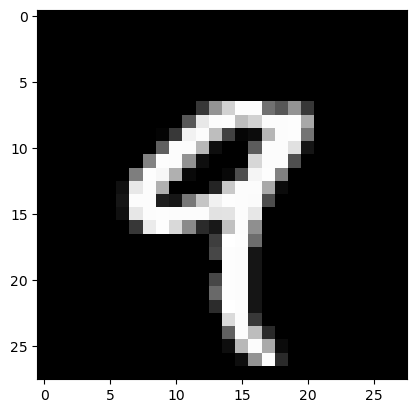

In [53]:
plt.imshow(sample[0].squeeze(0).numpy(), cmap='gray')

In [54]:
out = vae(sample[0].to(torch.float32))

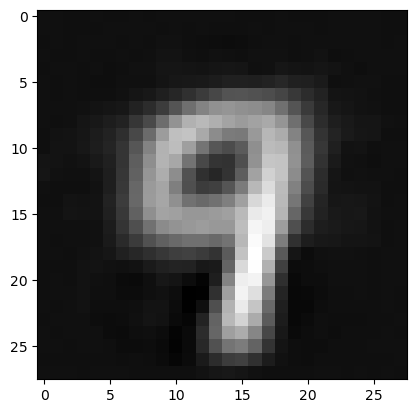

In [55]:
plt.imshow(out[0].squeeze(0).detach().numpy(), cmap='gray')

In [56]:
for i in range(10):
    sample = sample_image(i)
    mu, sigma = vae.encoder(sample[0].to(torch.float32))
    print(i, mu, sigma)

0 tensor([[-9.7540]], grad_fn=<AddmmBackward0>) tensor([[-0.3621]], grad_fn=<AddmmBackward0>)
1 tensor([[15.4859]], grad_fn=<AddmmBackward0>) tensor([[0.5470]], grad_fn=<AddmmBackward0>)
2 tensor([[-3.7878]], grad_fn=<AddmmBackward0>) tensor([[0.1136]], grad_fn=<AddmmBackward0>)
3 tensor([[-1.2120]], grad_fn=<AddmmBackward0>) tensor([[-0.0654]], grad_fn=<AddmmBackward0>)
4 tensor([[-0.1692]], grad_fn=<AddmmBackward0>) tensor([[-0.0056]], grad_fn=<AddmmBackward0>)
5 tensor([[-1.1363]], grad_fn=<AddmmBackward0>) tensor([[-0.1098]], grad_fn=<AddmmBackward0>)
6 tensor([[-5.2295]], grad_fn=<AddmmBackward0>) tensor([[0.0911]], grad_fn=<AddmmBackward0>)
7 tensor([[0.2951]], grad_fn=<AddmmBackward0>) tensor([[-0.0168]], grad_fn=<AddmmBackward0>)
8 tensor([[1.2771]], grad_fn=<AddmmBackward0>) tensor([[-0.0752]], grad_fn=<AddmmBackward0>)
9 tensor([[0.0190]], grad_fn=<AddmmBackward0>) tensor([[-0.0098]], grad_fn=<AddmmBackward0>)


In [57]:
import matplotlib as mpl

In [58]:
mpl.rcParams['figure.figsize'] =  10,10

In [59]:
x = np.linspace(-5, 10, num=250)

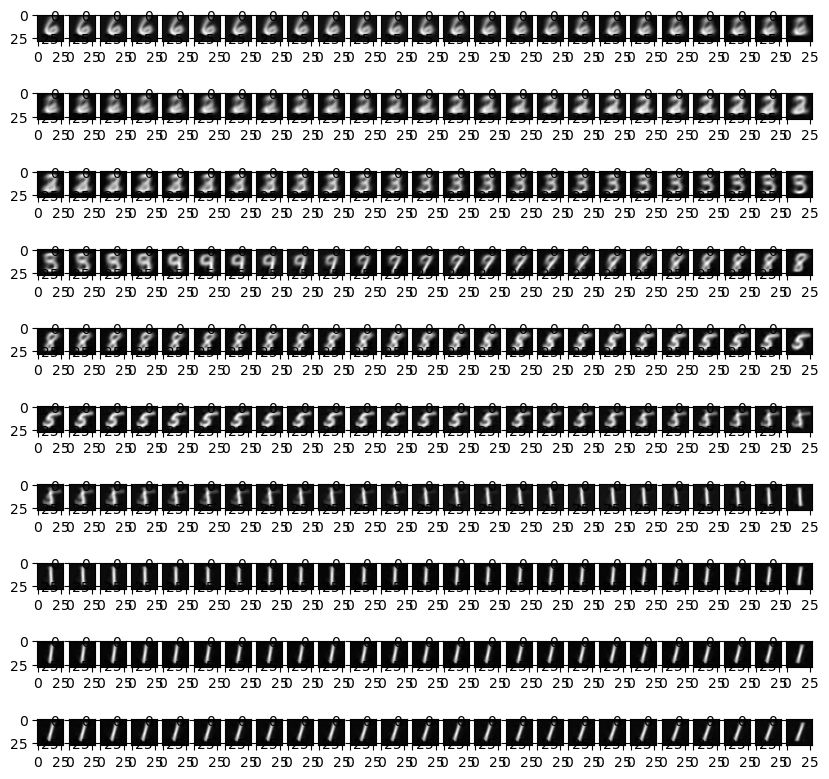

In [60]:
fig = plt.figure()
i = 1
for m in x:
    mu = torch.FloatTensor([[m]])
    std = torch.zeros_like(mu)
    epsilon = torch.rand_like(std)
    z = mu + epsilon*std
    out = vae.decoder(z)
    plt.subplot(10, 25, i)
    plt.imshow(out[0].squeeze(0).detach().numpy(), cmap='gray')
    i+=1

# Task: Multiple latent dimensions

Consider the same dataset and design a vae consisting of two latent dimensions. So you will have two means and two standard deviations

In [ ]:
# 1. adopt the encoder architecture to predict mu and sigma corresponding to each of the two latent dimensions
# 2. adopt the kl-div loss to consider multiple doimensions. Note that it is just the mean of the score across 
# each individual dimension
# 3. the decoder will now take as input a vector of size 2
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define KL divergence loss
def kl_div(mu, logvar):
    """KL divergence for a diagonal Gaussian distribution."""
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

# Encoder
class Encoder(nn.Module):
    def __init__(self, z=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1 = nn.Linear(32 * 7 * 7, 512)
        self.lin_m = nn.Linear(512, z)  # Predict μ
        self.lin_logvar = nn.Linear(512, z)  # Predict log(σ^2)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(inp.size(0), -1)
        out = self.lin1(out)
        mu = self.lin_m(self.relu(out))
        logvar = self.lin_logvar(self.relu(out))
        return mu, logvar

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 32 * 7 * 7)  # Input size is 2
        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, output_padding=1)
    
    def forward(self, z):
        out = self.fc(z)
        out = self.relu(out)
        out = out.view(-1, 32, 7, 7)
        out = self.deconv1(out)
        out = self.relu(out)
        out = self.deconv2(out)
        return torch.sigmoid(out)  # Ensure output is in [0, 1]

# Variational Autoencoder
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, X):
        mu, logvar = self.encoder(X)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)  # Reparameterization trick
        X_hat = self.decoder(z)
        return X_hat, mu, logvar

# Initialize model, optimizer, and criterion
vae = VariationalAutoencoder()
optimizer = optim.Adam(vae.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 15
for e in tqdm(range(epochs)):
    running_loss = 0
    batches = 0
    for X, label in trainloader:
        batches += 1
        X = X.float()
        X_hat, mu, logvar = vae(X)
        # Reconstruction loss + KL divergence loss
        recon_loss = criterion(X_hat, X)
        kl_loss = kl_div(mu, logvar).mean()
        loss = recon_loss + kl_loss
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss at the end of epoch {e}: {running_loss / batches}")

# Save the trained model
torch.save(vae.state_dict(), 'mnist_vae_2d.pt')

Sample images from each class and obtain the corresponding latent vector for each of them and create a scatter plot. Can you identify the clusters?

Change the number of dimensions to see how it impacts the results..